# Классификация текста с помощью трансформера BERT

Оригинальная идея подчерпнута отсюда https://www.kaggle.com/c/learn-ai-bbc и отсюда https://habr.com/ru/post/655517/


### Импорт библиотек

In [1]:
import re
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from bs4 import BeautifulSoup


tqdm.pandas()

device = torch.device('cuda')
print(device)

cuda


### Чтение нашего датасета, состоящего описаний категорий и ТНВЭД


In [2]:
df = pd.read_csv('dataset.csv', index_col=0)
display(df)

,OPISANIE_CLEAN,TNVED,TNVED2
0,части принадлежности аппаратуры поз 9025 военн...,9025,90
1,трансформаторы мощностью 1 ква 16 ква лом элек...,8504,85
2,клапаны запорные стали военного назначения,8481,84
3,устройства сигнализационные охранные устройств...,8531,85
4,вещества поверхностно активные органические ан...,3402,34
...,...,...,...
4177894,минеральное моторное масло всесезонное дизельн...,2710,27
4177895,синтетическое моторное масло всесезонное дизел...,3403,34
4177896,синтетическое моторное масло всесезонное дизел...,3403,34
4177897,масло трансмиссионное синтетической основе сод...,3403,34


In [3]:
df2 = pd.read_csv('tnved.csv', index_col=0)
df2 = df2.rename(columns={'TNVED_SHORT': 'TNVED'})
display(df2)

,OPISANIE_CLEAN,TNVED,TNVED2
,,,
1,лошади живые чистопородные племенные животные,101,1
2,лошади ослы мулы лошаки живые прочие,101,1
3,прочие лошади живые прочие,101,1
4,ослы живые,101,1
5,прочие мулы лошаки живые,101,1
...,...,...,...
12318,подлинники гравюр эстампов литографий,9702,97
12319,подлинники скульптур статуэток любых материалов,9703,97
12320,марки почтовые марки госпошлин знаки почтовой ...,9704,97


In [4]:
df_train = df.sample(n = 100000)
df_train = pd.concat([df_train,df2])

df_train['TNVED2']=df_train['TNVED2'].apply(lambda x: x - 2 if x > 77 else x-1)
display(df_train)

,OPISANIE_CLEAN,TNVED,TNVED2
3765276,крепежные изделия фурнитура пластмасс ввозятся...,3926,38
4039130,карты флэш памяти usb накопители содержащие за...,8523,83
1549633,шурупы дерева снабженные резьбой пазов насечек...,7318,72
484730,виноград свежий столовый сорт мерседес 16 июля...,806,7
3990828,автомобиль марки volkswagen модели polo vin xw...,8703,85
...,...,...,...
12318,подлинники гравюр эстампов литографий,9702,95
12319,подлинники скульптур статуэток любых материалов,9703,95
12320,марки почтовые марки госпошлин знаки почтовой ...,9704,95
12321,коллекции предметы коллекционирования зоологии...,9705,95


### Загрузка претренированной модели

In [6]:
bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

### Разбиение выборок на текст и таргет

In [ ]:
import pickle
with open('X_train.pickle', 'rb') as handle:
    X_train = pickle.load(handle)
with open('y_train.pickle', 'rb') as handle:
    y_train = pickle.load(handle)
with open('X_test.pickle', 'rb') as handle:
    X_test = pickle.load(handle)
with open('y_test.pickle', 'rb') as handle:
    y_test = pickle.load(handle)

In [7]:
X = df_train['OPISANIE_CLEAN'].astype(str)
y = df_train['TNVED2'].astype(int)

X_train, y_train = X,y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [8]:
import pickle
with open('X_train.pickle', 'wb') as handle:
    pickle.dump(X_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_train.pickle', 'wb') as handle:
    pickle.dump(y_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('X_test.pickle', 'wb') as handle:
    pickle.dump(X_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_test.pickle', 'wb') as handle:
    pickle.dump(y_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

График длин текстов. Он поможет определить оптимальную длину последовательности токенов, чтобы избежать разреженных векторов.

<AxesSubplot:>

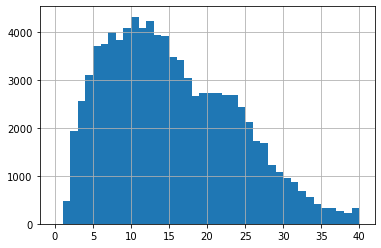

In [9]:
seq_len = [len(str(i).split()) for i in X_train]
pd.Series(seq_len).hist(bins = 40, range =(0,40))

### Токенизация текста
Берем длину 15

In [9]:
import pickle

with open('tokens_train.pickle', 'rb') as handle:
    tokens_train = pickle.load(handle)
    
with open('tokens_test.pickle', 'rb') as handle:
    tokens_test = pickle.load(handle)

In [10]:
token_len = 15

tokens_train = tokenizer.batch_encode_plus(
    X_train.values,
    max_length = token_len,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    X_test.values,
    max_length = token_len,
    padding = 'max_length',
    truncation = True
)

In [11]:
import pickle

with open('tokens_train.pickle', 'wb') as handle:
    pickle.dump(tokens_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('tokens_test.pickle', 'wb') as handle:
    pickle.dump(tokens_test, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Создание датасета для обучения из токенов

In [12]:
batch_size = 4


train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.values)

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

test_data =  TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)

In [13]:
print(test_data[0])

(tensor([   101,  75642,  42359, 114243,  98937,   2237,  55337,    852,  34832,
         27446,  28955,  72471,  29602,   8237,    102]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), tensor(61))


### Вместо обучения всего BERT добавим слой для классификации

In [13]:
for param in bert.parameters():
    param.requires_grad = False

class BERT_Arch(nn.Module):
    
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,96)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

### Загрузка модели в GPU

In [15]:
torch.cuda.empty_cache()

In [14]:
model = BERT_Arch(bert)

model = model.to(device)
from torch.optim import AdamW

optimizer = AdamW(model.parameters())

### Нормализация весов в зависимости от соотношения классов в выборке трейна

In [15]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights += 0.05

print(class_weights)

weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)
#cross_entropy = nn.CrossEntropyLoss()
cross_entropy = nn.NLLLoss(weight=weights)
epochs = 10

[  9.69959192   2.03307292   1.62312675   2.93892104  24.68185307
   1.34283207   1.68924766   0.99166038   3.88610827   7.42016076
   7.25008013   6.01184979  34.71705247 104.05115741   4.32402017
   2.42566096   3.11888661   2.72431548   2.1724726    1.43258555
   2.09369087   0.78297605   4.87479596  12.69878941   4.48606833
  14.9073082    0.87759542   1.81605739   1.06190315   1.07408142
  11.32723394   1.65001781   0.90091856   1.22737159   5.7227904
  49.31370614  12.8720605    1.4366821    0.25334791   0.2786298
  13.05014468   1.27675022   8.33327802   0.38803193  46.85052083
  21.32296402  12.20597944   0.98788619   3.34581133  39.05043403
  15.91458333   4.77732534  28.41395202   5.9000651    5.25005787
   4.9505781    7.14098801   9.6011267    5.55594363   8.26061769
   0.25419075   0.28871727   1.7066556    0.62178401   3.77912517
  34.71705247  18.40314542   1.69500952   1.87103194   1.00026438
   6.46103025   1.08198502   0.20463579   2.40770886  21.81768411
   1.5428395

/home/eugene/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95], y=3138558    60
429607     92
2614966    72
2774424    18
2940022    72
           ..
8234       72
744973     83
169952     47
1512868    26
3087034    83
Name: TNVED2, Length: 89857, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Функция для наглядного обучения модели

In [16]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    
    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        #print(loss)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        
    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    return avg_loss, total_preds

Функция для тестирования модели

In [17]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            #labels= labels.unsqueeze(1)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(test_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    
    return avg_loss, total_preds

Обучение новых слоев для задачи классификации

In [18]:
best_test_loss = float('inf')

train_losses = []
test_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))
    
    train_loss, _ = train()
    test_loss, _ = evaluate()
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Test loss: {test_loss:.3f}')
    
    

def train_acc():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    total_acc_test = 0

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            #labels= labels.unsqueeze(1)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            
            test_labels = labels.to(device)
            acc = (preds.argmax(dim=1) == test_labels).sum().item()
            total_acc_test += acc            
            
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            


    avg_loss = total_loss / len(test_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    print(f'Train Accuracy: {total_acc_test / len(total_preds): .3f}')
    return avg_loss, total_preds

ta,tb = train_acc()    
    
    
def acc():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    total_acc_test = 0

    for step, batch in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            #labels= labels.unsqueeze(1)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            
            test_labels = labels.to(device)
            acc = (preds.argmax(dim=1) == test_labels).sum().item()
            total_acc_test += acc            
            
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            


    avg_loss = total_loss / len(test_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    print(f'Test Accuracy: {total_acc_test / len(total_preds): .3f}')
    return avg_loss, total_preds

a,b = acc()




 Epoch1 / 10


100%|██████████| 5617/5617 [01:27<00:00, 63.86it/s]



Training loss: 2.534
Test loss: 1.802

 Epoch2 / 10


100%|██████████| 5617/5617 [01:31<00:00, 61.19it/s]



Training loss: 2.155
Test loss: 1.675

 Epoch3 / 10


100%|██████████| 5617/5617 [01:32<00:00, 60.69it/s]



Training loss: 2.071
Test loss: 1.716

 Epoch4 / 10


100%|██████████| 5617/5617 [01:32<00:00, 60.94it/s]



Training loss: 2.058
Test loss: 1.660

 Epoch5 / 10


100%|██████████| 5617/5617 [01:32<00:00, 60.76it/s]



Training loss: 2.048
Test loss: 1.589

 Epoch6 / 10


100%|██████████| 5617/5617 [01:32<00:00, 60.84it/s]



Training loss: 2.039
Test loss: 1.701

 Epoch7 / 10


100%|██████████| 5617/5617 [01:32<00:00, 60.67it/s]



Training loss: 2.019
Test loss: 1.677

 Epoch8 / 10


100%|██████████| 5617/5617 [01:18<00:00, 71.42it/s]



Training loss: 2.019
Test loss: 1.570

 Epoch9 / 10


100%|██████████| 5617/5617 [01:32<00:00, 60.49it/s]



Training loss: 2.007
Test loss: 1.527

 Epoch10 / 10


100%|██████████| 5617/5617 [01:32<00:00, 60.81it/s]



Training loss: 2.001
Test loss: 1.636


100%|██████████| 22465/22465 [06:16<00:00, 59.65it/s]


Train Accuracy:  0.680


100%|██████████| 5617/5617 [01:33<00:00, 60.06it/s]

Test Accuracy:  0.672


Загружаем лучшую модель для предсказания

In [43]:
model.eval()

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [ ]:
#path = '96_v1_saved_weights.pt'
#model.load_state_dict(torch.load(path))
#model.eval()

### Предсказываем


In [ ]:
def predict_dataloader(predict_dataloader):
    total_preds = []
    total_labels = []
    
    for step, batch in tqdm(enumerate(predict_dataloader), total = len(predict_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            preds = preds.detach().cpu().numpy()    
            preds = preds.argmax(axis=1)
            labels = labels.cpu().numpy()
            total_preds.append(preds)
            total_labels.append(labels)
            
    return total_preds, total_labels


def predict_df(df):
    df = df.copy()
    batch_size = 1
    tokens_predict = tokenizer.batch_encode_plus(
        df['OPISANIE_CLEAN'].values,
        max_length = 15,
        padding = 'max_length',
        truncation = True
    )
    
    total_preds = []
    
    predict_seq = torch.tensor(tokens_predict['input_ids'])
    predict_mask = torch.tensor(tokens_predict['attention_mask'])
    predict_data =  TensorDataset(predict_seq, predict_mask)
    predict_sampler = SequentialSampler(predict_data)
    predict_dataloader = DataLoader(predict_data, sampler = predict_sampler, batch_size = batch_size)
    
    
    for step, batch in tqdm(enumerate(predict_dataloader), total = len(predict_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            preds = preds.detach().cpu().numpy()    
            preds = np.argmax(preds)
            total_preds.append(preds)
    df['target'] = total_preds
    return df

#pred_df = predict_df(test_df)
#display(pred_df)

a, b = predict_dataloader(test_dataloader)

a = np.hstack(a)
b = np.hstack(b)

for x in zip(a,b):
    print(x[0], x[1])

In [76]:
def acc():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    total_acc_test = 0

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            #labels= labels.unsqueeze(1)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            
            test_labels = labels.to(device)
            acc = (preds.argmax(dim=1) == test_labels).sum().item()
            total_acc_test += acc            
            
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            


    avg_loss = total_loss / len(test_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    print(f'Test Accuracy: {total_acc_test / len(total_preds): .3f}')
    return avg_loss, total_preds

a,b = acc()

100%|██████████| 16929/16929 [04:50<00:00, 58.37it/s]


Test Accuracy:  0.664


In [21]:
from sklearn import metrics
print(metrics.classification_report(a,b))

              precision    recall  f1-score   support

           0       0.70      0.88      0.78        16
           1       0.90      0.76      0.82       140
           2       0.91      0.64      0.75       242
           3       0.63      0.76      0.69        75
           4       0.00      0.00      0.00         1
           5       0.87      0.98      0.92       167
           6       0.83      0.49      0.61       212
           7       0.71      0.76      0.73       221
           8       0.56      0.68      0.62        47
           9       0.58      0.48      0.53        31
          10       0.46      0.85      0.60        20
          11       0.50      0.66      0.57        32
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.46      0.72      0.56        43
          15       0.79      0.40      0.53       176
          16       0.34      0.62      0.44        48
          17       0.80    

/home/eugene/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
